In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary

In [3]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm

/tmp/ipykernel_3002280/464873755.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


### Paths

In [4]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [5]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SSMfigdir = join(figroot, "SSM_raven")

In [6]:
import pandas as pd

# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [7]:
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven’: File exists


### Rule learning dynamics function

Function to parse the experiment string

In [8]:
import re
def extract_and_convert(string):
    # Pattern to match the "0_16" part and convert to float 0.16
    match1 = re.search(r'stream(\d+)_(\d+)', string)
    if match1:
        num1 = int(match1.group(1))
        num2 = int(match1.group(2))
        result = float(f"{num1}.{num2}")
        return result
    
    # Pattern to match the "16M" part and convert to integer 16
    match2 = re.search(r'stream(\d+)M', string)
    if match2:
        result = int(match2.group(1))
        return result
    
    return None

Functions to load the samples and eval stats, plot the data

In [9]:
def sweep_collect_eval_data(expname, exproot, prefix=None):
    assert os.path.exists(join(exproot, expname, "samples")), expname  
    # print(sorted(os.listdir(join(exproot, expname, "samples"))))
    print(f"Extracted data from {join(exproot, expname, 'samples')}")
    print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0])
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if prefix in f])
    eval_col = {}
    for epoch_num in tqdm(epoch_nums):
        samples_eval = torch.load(join(exproot, expname, 'samples', f"{prefix}{epoch_num}.pt"))
        eval_col[epoch_num] = samples_eval
    return eval_col

In [10]:
def extract_rule_list_from_eval_col(eval_col, is_abinit = False):
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        if is_abinit:
            rule_list_all.append(eval_col[epoch]['rule_col_list_abinit'])
            consistency_all.append((eval_col[epoch]['C3_list_abinit'], eval_col[epoch]['C2_list_abinit']))
        else:
            rule_list_all.append(eval_col[epoch]['rule_col_list'])
            consistency_all.append((eval_col[epoch]['C3_list'], eval_col[epoch]['C2_list']))
    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all


def extract_rule_list_from_eval_col_Diffusion(eval_col, ):
    print("diffusion model, just fetch ab init generation")
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        rule_list_all.append(eval_col[epoch]['rule_col'])
        consistency_all.append((eval_col[epoch]['c3_list'], eval_col[epoch]['c2_list']))

    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all

In [11]:
def format_rule_list_to_mat(rule_list_all, consistency_all):
    """Format the collected rule_list_all and consistency_all into rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat.
    for plotting purposes.

    Args:
        rule_list_all: np.array, dtype object, shape=(num_epoch, num_sample, 3). 
        consistency_all: np.array, dtype object, shape=(num_epoch, 2, num_sample). 
                    where the 2nd dimension is the consistency of C3 and C2 rules corrspondingly. 

    Returns:
        rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons3_rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons2_rule_cnt_mat: np.array, shape=(num_epoch, 40).
    """
    epoch_num = rule_list_all.shape[0]
    rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
        rule_pool_all.append(rule_pool)
    # plot the number of rules == rule_i for each generation
    rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        rule_cnt_mat[i, rule_uniq] = counts

    cons3_rule_pool_all = []
    cons2_rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
        cons3_rule_pool_all.append(rule_pool)
        rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
        cons2_rule_pool_all.append(rule_pool)

    cons3_rule_cnt_mat = np.zeros((epoch_num, 40))
    cons2_rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = cons3_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons3_rule_cnt_mat[i, rule_uniq] = counts
        rule_pool = cons2_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons2_rule_cnt_mat[i, rule_uniq] = counts
    return rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat

In [12]:
from rule_new_utils import rule_table, relation_dict, attribute_dict
from circuit_toolkit.plot_utils import saveallforms
def visualize_indiv_rule_dynam(epoch_list, rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(epoch_list, smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {rule_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

In [13]:
def visualize_train_heldout_rule(epoch_list, plot_mat, heldout_id, 
                                 normalizer=None, titlestr="", 
                                 reflevel=None):#conv_wid=10, axs=None):
    heldout_mask = np.zeros((40,)).astype(bool)
    heldout_mask[heldout_id] = True
    if normalizer is not None:
        plot_mat = plot_mat / normalizer
    figh, axs = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, plot_mat[:, heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.suptitle(titlestr) # "Accuracy of C3 for each rule type"
    plt.show()
    return figh
    

In [14]:
tb_data_col_DiT = extract_all_runs(DiT_exproot)

Extracted data from 096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs
Extracted data from 091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs
Extracted data from 085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs
Extracted data from 099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
Extracted data from 087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs
Extracted data from 090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs
Extracted data from 095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs
Extracted data from 084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200/tensorboard_logs
Extracted data from 086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs
Extracted data from 083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149/tensorboard_logs
Ex

In [15]:
for key in tb_data_col_DiT.keys():
    print(key)
    if tb_data_col_DiT[key]["step"].max() < 999999:
        print(tb_data_col_DiT[key]["step"].max())
        print("unfinished run") 

096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs
099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
333000
unfinished run
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs
095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs
084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200/tensorboard_logs
8900
unfinished run
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs
083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149/tensorboard_logs
9500
unfinished run
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_202407

In [ ]:
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_DiT = extract_last_step_summary(tb_data_col_DiT, simplify_runname, ())
syndf_DiT

tag,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,step,step/epoch
run_name,,,,,,,,,,,,
096-uncond-DiT_B_1-stream0_16M,0.093656,0.089743,0.756673,4649.0,0.130371,267.0,0.604004,1237.0,8.781941,096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs,1000000,1000000
091-uncond-DiT_B_1-stream16M,0.093849,0.094762,0.754069,4633.0,0.125000,256.0,0.603027,1235.0,8.272856,091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs,1000000,1000000
085-uncond-DiT_S_1-stream0_16M,0.094453,0.089580,0.737956,4534.0,0.111816,229.0,0.595703,1220.0,18.965296,085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs,1000000,1000000
087-uncond-DiT_S_1-stream16M,0.094620,0.098189,0.780762,4797.0,0.122559,251.0,0.633789,1298.0,16.748566,087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs,1000000,1000000
090-uncond-DiT_S_1-stream0_16M_heldout0,0.095534,0.094757,0.734701,4514.0,0.142090,291.0,0.571289,1170.0,18.949669,090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs,1000000,1000000
095-uncond-DiT_B_1-stream16M_heldout0,0.096062,0.096317,0.756348,4647.0,0.141113,289.0,0.594727,1218.0,8.739494,095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs,1000000,1000000
084-uncond-DiT_B_1-stream16M,0.112006,0.116013,0.487793,2997.0,0.060547,124.0,0.000000,0.0,8.792282,084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200/tensorboard_logs,8900,7500
086-uncond-DiT_S_1-stream1_6M,0.094237,0.098248,0.792806,4871.0,0.117676,241.0,0.650391,1332.0,18.855453,086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs,1000000,1000000
083-uncond-DiT_S_1-stream16M,0.112773,0.121929,0.486003,2986.0,0.062988,129.0,0.000488,1.0,19.033159,083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149/tensorboard_logs,9500,7500


In [ ]:
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
excluded_runs = [
    "084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200/tensorboard_logs",
    "083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149/tensorboard_logs",
]
syndf_DiT = extract_last_step_summary(tb_data_col_DiT, simplify_runname, excluded_runs)

Excluding 084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200/tensorboard_logs
Excluding 083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149/tensorboard_logs


In [21]:
runs = ["090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs",
        "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs",]
labels = ["DiT_S_1 0.16M", "DiT_S_1 0.016M"]

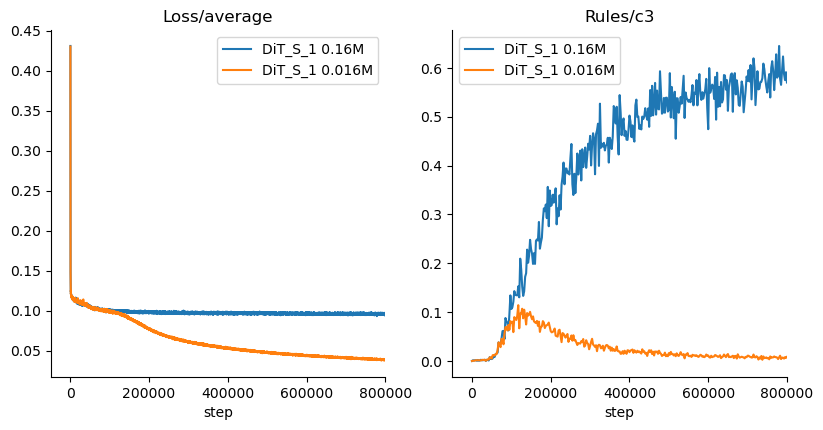

In [32]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_datascale_cmp_curve"
plt.figure(figsize=(9.5, 4.5))
plt.subplot(1, 2, 1)
varname = "Loss/average"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label)
plt.legend()
plt.xlim(None, 800000)
plt.xlabel("step")
plt.title(varname)
plt.subplot(1, 2, 2)
varname = "Rules/c3"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label)
plt.legend()
plt.xlim(None, 800000)
plt.xlabel("step")
plt.title(varname)
saveallforms(figdir, "DiT_S_1_0.16M_0.016M_cmp_curve")
plt.show()

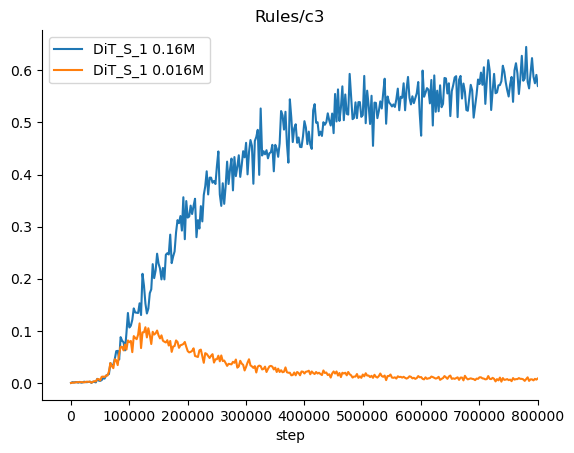

In [27]:
varname = "Rules/c3"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label)
plt.legend()
plt.xlim(None, 800000)
plt.xlabel("step")
plt.title(varname)
plt.show()